In [80]:
# Preprocessing

In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated"

import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\Cities.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\Conferences.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MConferenceTourneyGames.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MGameCities.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MMasseyOrdinals.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MNCAATourneyCompactResults.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MNCAATourneyDetailedResults.csv
C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MNCAATourneySeedRoundSlots.csv
C:\User

There is an abundance of data. Although not all of it might be used, it's still important to inspect each dataset. Let's start with the tournament teams, tournament seeding, and regular season results.

In [82]:
teams_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MTeams.csv")

print("Men's tournament teams")
print(teams_m.head())

teams_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WTeams.csv")

print("\nWomen's tournament teams")
print(teams_w.head())

seeding_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MNCAATourneySeeds.csv")

print("\nMen's tournament seeds")
print(seeding_m.head())

seeding_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WNCAATourneySeeds.csv")

print("\nWomen's tournament seeds")
print(seeding_w.head())

tournament_compact_results_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MNCAATourneyCompactResults.csv")

print("\nMen's Compact Tournament Results")
print(tournament_compact_results_m.head())

tournament_compact_results_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WNCAATourneyCompactResults.csv")

print("\nWomen's Compact Tournament Results")
print(tournament_compact_results_w.head())

tournament_detailed_results_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MNCAATourneyDetailedResults.csv")

print("\nMen's Detailed Tournament Results")
print(tournament_detailed_results_m.head())

tournament_detailed_results_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WNCAATourneyDetailedResults.csv")

print("\nWomen's Detailed Tournament Results")
print(tournament_detailed_results_w.head())

regular_season_compact_results_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MRegularSeasonCompactResults.csv")

print("\nMen's Regular Season Compact Results")
print(regular_season_compact_results_m.head())

regular_season_compact_results_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WRegularSeasonCompactResults.csv")

print("\nWomen's Regular Season Compact Results")
print(regular_season_compact_results_w.head())

regular_season_detailed_results_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MRegularSeasonDetailedResults.csv")

print("\nMen's Detailed Season Compact Results")
print(regular_season_detailed_results_m.head())

regular_season_detailed_results_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WRegularSeasonDetailedResults.csv")

print("\nMen's Detailed Season Compact Results")
print(regular_season_detailed_results_w.head())

conferences_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MTeamConferences.csv")

print("\nMen's Team Conferences")
print(conferences_m.head())

conferences_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WTeamConferences.csv")

print("\nWomen's Team Conferences")
print(conferences_w.head())

Men's tournament teams
   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2025
1    1102    Air Force           1985          2025
2    1103        Akron           1985          2025
3    1104      Alabama           1985          2025
4    1105  Alabama A&M           2000          2025

Women's tournament teams
   TeamID     TeamName
0    3101  Abilene Chr
1    3102    Air Force
2    3103        Akron
3    3104      Alabama
4    3105  Alabama A&M

Men's tournament seeds
   Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

Women's tournament seeds
   Season Seed  TeamID
0    1998  W01    3330
1    1998  W02    3163
2    1998  W03    3112
3    1998  W04    3301
4    1998  W05    3272

Men's Compact Tournament Results
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985    

# Exploratory Data Analysis

In [83]:
def get_seed(df: pd.DataFrame) -> pd.DataFrame:
    df['seed'] = df['Seed'].apply(lambda x: int(x[1:3]))
    # Make sure seed is an int
    df['seed'] = df['seed'].astype(int)
    df.drop(columns=['Seed'], inplace=True)
    return df

seeding_by_season_m = get_seed(seeding_m)
seeding_by_season_w = get_seed(seeding_w)
print(seeding_by_season_m.head())
print(seeding_by_season_w.head())

   Season  TeamID  seed
0    1985    1207     1
1    1985    1210     2
2    1985    1228     3
3    1985    1260     4
4    1985    1374     5
   Season  TeamID  seed
0    1998    3330     1
1    1998    3163     2
2    1998    3112     3
3    1998    3301     4
4    1998    3272     5


# Feature Engineering

The next steps are to be able to extract the win loss records of each season of each team. We need to the margin of victory, strength of schedule, and simple rating system.

In [84]:
def margin_of_victory(df: pd.DataFrame) -> pd.DataFrame:
    # First calculate MOV for each game
    df_with_mov = df.copy()
    df_with_mov['MOV'] = df_with_mov['WScore'] - df_with_mov['LScore']

    # Create dataframe for winning teams
    winners = df_with_mov[['Season', 'WTeamID', 'MOV']].rename(columns={'WTeamID': 'TeamID'})
    winners['Win'] = 1
    winners['Loss'] = 0

    # Create dataframe for losing teams (negative MOV)
    losers = df_with_mov[['Season', 'LTeamID', 'MOV']].rename(columns={'LTeamID': 'TeamID'})
    losers['MOV'] = -losers['MOV']
    losers['Win'] = 0
    losers['Loss'] = 1

    # Combine both dataframes
    all_teams = pd.concat([winners, losers])

    # Group by Season and TeamID to get aggregate stats
    team_mov = all_teams.groupby(['Season', 'TeamID']).agg(
        avg_MOV=('MOV', 'mean'),
        total_MOV=('MOV', 'sum'),
        games_played=('MOV', 'count'),
        wins=('Win', 'sum'),
        losses=('Loss', 'sum')
    ).reset_index()

    # Calculate winning percentage
    team_mov['win_pct'] = team_mov['wins'] / team_mov['games_played']

    return team_mov

mov_m = margin_of_victory(regular_season_compact_results_m)
mov_w = margin_of_victory(regular_season_compact_results_w)

print(mov_m.head())
print(mov_w.head())    

   Season  TeamID   avg_MOV  total_MOV  games_played  wins  losses   win_pct
0    1985    1102 -5.791667       -139            24     5      19  0.208333
1    1985    1103 -3.043478        -70            23     9      14  0.391304
2    1985    1104  7.800000        234            30    21       9  0.700000
3    1985    1106 -3.791667        -91            24    10      14  0.416667
4    1985    1108  7.960000        199            25    19       6  0.760000
   Season  TeamID    avg_MOV  total_MOV  games_played  wins  losses   win_pct
0    1998    3102 -20.625000       -495            24     4      20  0.166667
1    1998    3103  -5.862069       -170            29    11      18  0.379310
2    1998    3104  13.433333        403            30    21       9  0.700000
3    1998    3106  -7.952381       -167            21     6      15  0.285714
4    1998    3108   1.304348         30            23    12      11  0.521739


In [85]:
def simple_rating_system(df: pd.DataFrame, mov: pd.DataFrame) -> pd.DataFrame:
    # The mov is passed in from the margin_of_victory function, so avg_MOV is already calculated
    srs = mov.copy()

    # We initialize the SRS to the average MOV
    srs['SRS'] = srs['avg_MOV']

    # We iteratively calculate the SRS until it converges
    for i in range(100):
        # Get opponents' SRS for games where team was winner
        winner_sos = df.merge(srs[['Season', 'TeamID', 'SRS']], 
                             left_on=['Season', 'WTeamID'], 
                             right_on=['Season', 'TeamID'], 
                             how='left')
        winner_sos = winner_sos.merge(srs[['Season', 'TeamID', 'SRS']], 
                                    left_on=['Season', 'LTeamID'], 
                                    right_on=['Season', 'TeamID'], 
                                    how='left',
                                    suffixes=['_team', '_opp'])
        
        # Get opponents' SRS for games where team was loser
        loser_sos = df.merge(srs[['Season', 'TeamID', 'SRS']], 
                            left_on=['Season', 'LTeamID'], 
                            right_on=['Season', 'TeamID'], 
                            how='left')
        loser_sos = loser_sos.merge(srs[['Season', 'TeamID', 'SRS']], 
                                   left_on=['Season', 'WTeamID'], 
                                   right_on=['Season', 'TeamID'], 
                                   how='left',
                                   suffixes=['_team', '_opp'])
        
        # Combine and calculate average opponent SRS
        winner_opponents = winner_sos[['Season', 'TeamID_team', 'SRS_opp']].rename(
            columns={'TeamID_team': 'TeamID'})
        loser_opponents = loser_sos[['Season', 'TeamID_team', 'SRS_opp']].rename(
            columns={'TeamID_team': 'TeamID'})
        
        all_opponents = pd.concat([winner_opponents, loser_opponents])
        sos = all_opponents.groupby(['Season', 'TeamID'])['SRS_opp'].mean().reset_index()
        sos.columns = ['Season', 'TeamID', 'SOS']

        # Update SRS
        srs = srs.merge(sos, on=['Season', 'TeamID'], how='left')
        srs['SRS'] = srs['avg_MOV'] + srs['SOS']
        srs.drop(columns=['SOS'], inplace=True)

    return srs

srs_m = simple_rating_system(regular_season_compact_results_m, mov_m)
srs_w = simple_rating_system(regular_season_compact_results_w, mov_w)

print(srs_m.head())
print(srs_w.head())

   Season  TeamID   avg_MOV  total_MOV  games_played  wins  losses   win_pct  \
0    1985    1102 -5.791667       -139            24     5      19  0.208333   
1    1985    1103 -3.043478        -70            23     9      14  0.391304   
2    1985    1104  7.800000        234            30    21       9  0.700000   
3    1985    1106 -3.791667        -91            24    10      14  0.416667   
4    1985    1108  7.960000        199            25    19       6  0.760000   

         SRS  
0  -5.875628  
1  -7.021700  
2  14.948632  
3 -10.042809  
4   2.207007  
   Season  TeamID    avg_MOV  total_MOV  games_played  wins  losses   win_pct  \
0    1998    3102 -20.625000       -495            24     4      20  0.166667   
1    1998    3103  -5.862069       -170            29    11      18  0.379310   
2    1998    3104  13.433333        403            30    21       9  0.700000   
3    1998    3106  -7.952381       -167            21     6      15  0.285714   
4    1998    3108   1.30

We will now estimate possessions in order to derive Offensive Rating, Defensive Rating, and Net Rating.

The formula for deriving possessions is Possessions = 0.96 \times (FGA + TO + 0.44 \times FTA - ORB)

In [86]:
def advanced_ratings(df: pd.DataFrame) -> pd.DataFrame:
    # Estimate possessions
    df['WPossessions'] = 0.96 * (df['WFGA'] + df['WTO'] + 0.44 * df['WFTA'] - df['WOR'])
    df['LPossessions'] = 0.96 * (df['LFGA'] + df['LTO'] + 0.44 * df['LFTA'] - df['LOR'])
    
    # Create dataframes for teams when they win
    w_teams = df[['Season', 'WTeamID', 'WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WPossessions', 'LPossessions']].copy()
    w_teams.columns = ['Season', 'TeamID', 'PointsScored', 'PointsAllowed', 'FGM', 'FGA', 'FGM3', 'FGA3', 'TFM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OwnPossessions', 'OppPossessions']
    
    # Create dataframes for teams when they lose
    l_teams = df[['Season', 'LTeamID', 'LScore', 'WScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LPossessions', 'WPossessions']].copy()
    l_teams.columns = ['Season', 'TeamID', 'PointsScored', 'PointsAllowed', 'FGM', 'FGA', 'FGM3', 'FGA3', 'TFM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OwnPossessions', 'OppPossessions']
    
    # Combine both datasets
    all_games = pd.concat([w_teams, l_teams])
    
    # Group by Season and TeamID to get all metrics
    team_ratings = all_games.groupby(['Season', 'TeamID']).agg(
        total_points_scored=('PointsScored', 'sum'),
        total_points_allowed=('PointsAllowed', 'sum'),
        total_field_goals_made=('FGM', 'sum'),
        total_field_goals_attempted=('FGA', 'sum'),
        total_three_point_field_goals_made=('FGM3', 'sum'),
        total_three_point_field_goals_attempted=('FGA3', 'sum'),
        total_free_throws_made=('TFM', 'sum'),
        total_free_throws_attempted=('FTA', 'sum'),
        total_offensive_rebounds=('OR', 'sum'),
        total_defensive_rebounds=('DR', 'sum'),
        total_assists=('Ast', 'sum'),
        total_turnovers=('TO', 'sum'),
        total_steals=('Stl', 'sum'),
        total_blocks=('Blk', 'sum'),
        total_PFs=('PF', 'sum'),
        total_possessions=('OwnPossessions', 'sum'),
        total_opp_possessions=('OppPossessions', 'sum'),
        games_played=('PointsScored', 'count')
    ).reset_index()
    
    # Calculate advanced metrics
    team_ratings['total_points_diff'] = team_ratings['total_points_scored'] - team_ratings['total_points_allowed']
    team_ratings['points_per_game'] = team_ratings['total_points_scored'] / team_ratings['games_played']
    team_ratings['field_goal_percentage'] = 100 * team_ratings['total_field_goals_made'] / team_ratings['total_field_goals_attempted']
    team_ratings['field_goals_made_per_game'] = team_ratings['total_field_goals_made'] / team_ratings['games_played']
    team_ratings['three_point_percentage'] = 100 * team_ratings['total_three_point_field_goals_made'] / team_ratings['total_three_point_field_goals_attempted']
    team_ratings['three_point_field_goals_made_per_game'] = team_ratings['total_three_point_field_goals_made'] / team_ratings['games_played']
    team_ratings['free_throw_percentage'] = 100 * team_ratings['total_free_throws_made'] / team_ratings['total_free_throws_attempted']
    team_ratings['offensive_rebounds_per_game'] = team_ratings['total_offensive_rebounds'] / team_ratings['games_played']
    team_ratings['defensive_rebounds_per_game'] = team_ratings['total_defensive_rebounds'] / team_ratings['games_played']
    team_ratings['rebounds_per_game'] = team_ratings['offensive_rebounds_per_game'] + team_ratings['defensive_rebounds_per_game']
    team_ratings['assists_per_game'] = team_ratings['total_assists'] / team_ratings['games_played']
    team_ratings['turnovers_per_game'] = team_ratings['total_turnovers'] / team_ratings['games_played']
    team_ratings['steals_per_game'] = team_ratings['total_steals'] / team_ratings['games_played']
    team_ratings['blocks_per_game'] = team_ratings['total_blocks'] / team_ratings['games_played']
    team_ratings['personal_fouls_per_game'] = team_ratings['total_PFs'] / team_ratings['games_played']
    team_ratings['offensive_rating'] = 100 * team_ratings['total_points_scored'] / team_ratings['total_possessions']
    team_ratings['defensive_rating'] = 100 * team_ratings['total_points_allowed'] / team_ratings['total_opp_possessions']
    team_ratings['net_rating'] = team_ratings['offensive_rating'] - team_ratings['defensive_rating']
    
    return team_ratings

ratings_init_m = advanced_ratings(regular_season_detailed_results_m)
ratings_init_w = advanced_ratings(regular_season_detailed_results_w)

print(ratings_init_m.head())
print(ratings_init_w.head())

   Season  TeamID  total_points_scored  total_points_allowed  \
0    2003    1102                 1603                  1596   
1    2003    1103                 2127                  2110   
2    2003    1104                 1940                  1820   
3    2003    1105                 1866                  1993   
4    2003    1106                 1781                  1785   

   total_field_goals_made  total_field_goals_attempted  \
0                     536                         1114   
1                     733                         1508   
2                     673                         1601   
3                     634                         1602   
4                     656                         1548   

   total_three_point_field_goals_made  \
0                                 219   
1                                 147   
2                                 178   
3                                 197   
4                                 171   

   total_three_poin

At this point, we need to start narrowing down the variables of interest.
Here are the ones we will include:
- Season
- TeamID
- ConfAbbrev
- offensive_rating
- defensive_rating
- net_rating
- win_pct
- Seed
- Seed Difference
- rebounds_per_game
- assists_per_game
- steals_per_game
- blocks_per_game
- turnovers_per_game
- personal_fouls_per_game
- field_goal_percentage
- field_goals_made_per_game
- three_point_percentage
- three_point_field_goals_made_per_game
- total_points_scored

In [87]:
def get_team_conference(df: pd.DataFrame, conferences: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(conferences, on=['TeamID', 'Season'], how='left')
    return df

ratings_conference_m = get_team_conference(ratings_init_m, conferences_m)
ratings_conference_w = get_team_conference(ratings_init_w, conferences_w)

def get_seed(df: pd.DataFrame, seeding: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(seeding, on=['TeamID', 'Season'], how='left')
    return df

ratings_seed_m = get_seed(ratings_conference_m, seeding_by_season_m)
ratings_seed_w = get_seed(ratings_conference_w, seeding_by_season_w)

def drop_unnecessary_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns = ['total_points_allowed', 'total_field_goals_made', 'total_field_goals_attempted', 
               'total_three_point_field_goals_made', 'total_three_point_field_goals_attempted', 'total_free_throws_made', 
               'total_free_throws_attempted', 'total_offensive_rebounds', 'total_defensive_rebounds', 'total_assists', 
               'total_turnovers', 'total_steals', 'total_blocks', 'total_PFs', 'total_possessions', 
               'total_opp_possessions', 'games_played']
    df.drop(columns=columns, inplace=True)
    return df

# Drop unnecessary columns
ratings_m = drop_unnecessary_columns(ratings_seed_m)
ratings_w = drop_unnecessary_columns(ratings_seed_w)

print(ratings_m.head())
print(ratings_w.head())

   Season  TeamID  total_points_scored  total_points_diff  points_per_game  \
0    2003    1102                 1603                  7        57.250000   
1    2003    1103                 2127                 17        78.777778   
2    2003    1104                 1940                120        69.285714   
3    2003    1105                 1866               -127        71.769231   
4    2003    1106                 1781                 -4        63.607143   

   field_goal_percentage  field_goals_made_per_game  three_point_percentage  \
0              48.114901                  19.142857               37.564322   
1              48.607427                  27.148148               33.870968   
2              42.036227                  24.035714               32.014388   
3              39.575531                  24.384615               36.481481   
4              42.377261                  23.428571               34.615385   

   three_point_field_goals_made_per_game  free_throw_per

Now that we have the data, we can start to build the model using XGBoost.
The dataframes ratings_m and ratings_w should have all the relevant data we need to build the model.
But the model will need to be able to take in as input all possible matchups between two regular season teams in each season.

In [88]:
# Import relevant libraries

# xgboost related libraries:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# sklearn related libraries:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Setting up the data

y_actual_m = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\MNCAATourneyCompactResults.csv")
y_actual_w = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data\WNCAATourneyCompactResults.csv")

base_data_m = ratings_m.copy()
base_data_w = ratings_w.copy()




y_actual needs to be augmented to include all possible matchups. If a matchup is not in the tourney results, then WScore will be total points scored by the winning team and LScore will be total points scored by the losing team.
This is because the target variable is a float with range [0,1] that predicts the probability of the winning team winning the matchup.
We'll have to use point spread to determine the target variable. Calculations should be based on betting line conventions.
If two teams are in the tournamenet, then the target variable will be a sigmoid curve with a mean of 0.5 and a standard deviation of 0.1. 
The curve will be shifted to the right if the higher seed is the winning team and to the left if the lower seed is the winning team.

In [89]:
# We will need to reshape the data so that all possible matchups are included in the data. This will be done by creating a new dataframe that includes all possible matchups between two teams in each season.

def create_all_matchups(ratings_df):
    """
    Create all possible matchups between teams for each season,
    ensuring no duplicates (TeamA vs TeamB and TeamB vs TeamA)
    """
    # List to store all matchups
    all_matchups = []
    
    # For each season
    for season in ratings_df['Season'].unique():
        # Get teams for this season
        season_teams = ratings_df[ratings_df['Season'] == season]['TeamID'].tolist()
        
        # Create all possible matchups where TeamID1 < TeamID2 to avoid duplicates
        for i, team1 in enumerate(season_teams):
            for team2 in season_teams[i+1:]:
                all_matchups.append({'Season': season, 'TeamID1': team1, 'TeamID2': team2})
    
    # Convert to DataFrame
    matchups_df = pd.DataFrame(all_matchups)
    
    return matchups_df

# Create all possible matchups for men's and women's teams
matchups_m = create_all_matchups(ratings_m)
matchups_w = create_all_matchups(ratings_w)

print(f"Number of men's matchups: {len(matchups_m)}")
print(f"Number of women's matchups: {len(matchups_w)}")
print(matchups_m.head())


Number of men's matchups: 1381961
Number of women's matchups: 978221
   Season  TeamID1  TeamID2
0    2003     1102     1103
1    2003     1102     1104
2    2003     1102     1105
3    2003     1102     1106
4    2003     1102     1107


The next step is to fill in the target values for all possible combinations.
The formula involves the game's point spread (if available), the seed difference between 2 teams (if available), the difference in net rating between the 2 teams, and the difference in SRS between the two teams.
The evaluation method uses the Brier Score, which is used by the Kaggle competition to evaluate the model.

In [90]:
def fill_in_tourney_results(df: pd.DataFrame, tourney_results: pd.DataFrame) -> pd.DataFrame:
    """
    This function isn't the final model. It's just meant to fill in the target variable.
    """

    # Let's merge the matchups with the actual tournament results, we need to preserve all hypothetical matchups
    # First, standardize the tournament results to match our matchup format
    # Create a copy of tournament_results
    tourney_std = tourney_results.copy()
    
    # Ensure WTeamID and LTeamID are integers
    tourney_std['WTeamID'] = tourney_std['WTeamID'].astype(int)
    tourney_std['LTeamID'] = tourney_std['LTeamID'].astype(int)

    # Create columns to match our standardized format where TeamID1 < TeamID2
    tourney_std['TeamID1'] = tourney_std.apply(lambda row: min(row['WTeamID'], row['LTeamID']), axis=1)
    tourney_std['TeamID2'] = tourney_std.apply(lambda row: max(row['WTeamID'], row['LTeamID']), axis=1)
    
    # Add a column to track whether TeamID1 was the winner
    tourney_std['TeamID1_Won'] = tourney_std['TeamID1'] == tourney_std['WTeamID']

    # Add a data source column to identify the source of each result
    tourney_std['DataSource'] = 'Tournament'

    # Select only the columns we need from tourney_std
    tourney_cols = ['Season', 'TeamID1', 'TeamID2', 'TeamID1_Won', 'WScore', 'LScore', 'DataSource']
    tourney_subset = tourney_std[tourney_cols]
    
    # Merge with our matchups dataframe
    result_df = df.merge(tourney_subset, on=['Season', 'TeamID1', 'TeamID2'], how='right')

    return result_df

y_actual_m = tournament_detailed_results_m
y_actual_w = tournament_detailed_results_w

merged_tourney_df_m = fill_in_tourney_results(matchups_m, y_actual_m)
merged_tourney_df_w = fill_in_tourney_results(matchups_w, y_actual_w)

display(merged_tourney_df_m)
display(merged_tourney_df_w)

,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2003,1411,1421,False,92,84,Tournament
1,2003,1112,1436,True,80,51,Tournament
2,2003,1113,1272,True,84,71,Tournament
3,2003,1141,1166,True,79,73,Tournament
4,2003,1143,1301,True,76,74,Tournament
...,...,...,...,...,...,...,...
1377,2024,1181,1301,False,76,64,Tournament
1378,2024,1345,1397,True,72,66,Tournament
1379,2024,1104,1163,False,86,72,Tournament
1380,2024,1301,1345,False,63,50,Tournament


,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2010,3124,3201,True,69,55,Tournament
1,2010,3173,3395,True,67,66,Tournament
2,2010,3181,3214,True,72,37,Tournament
3,2010,3199,3256,True,75,61,Tournament
4,2010,3207,3265,True,62,42,Tournament
...,...,...,...,...,...,...,...
889,2024,3163,3425,True,80,73,Tournament
890,2024,3234,3261,True,94,87,Tournament
891,2024,3163,3234,False,71,69,Tournament
892,2024,3301,3376,False,78,59,Tournament


In [91]:
def fill_in_regular_results(df: pd.DataFrame, regular_results: pd.DataFrame) -> pd.DataFrame:

    # We need to fill in the regular season matchups where the tournament results are missing
    regular_std = regular_results.copy()

    # Ensure WTeamID and LTeamID are integers
    regular_std['WTeamID'] = regular_std['WTeamID'].astype(int)
    regular_std['LTeamID'] = regular_std['LTeamID'].astype(int)

    # Create columns to match our standardized format where TeamID1 < TeamID2
    regular_std['TeamID1'] = regular_std.apply(lambda row: min(row['WTeamID'], row['LTeamID']), axis=1)
    regular_std['TeamID2'] = regular_std.apply(lambda row: max(row['WTeamID'], row['LTeamID']), axis=1)

    # Add a column to track whether TeamID1 was the winner, astype int to convert boolean to 0 or 1
    regular_std['TeamID1_Won'] = (regular_std['TeamID1'] == regular_std['WTeamID']).astype(int)
    
    # Add a column to identify this as regular season data
    regular_std['DataSource'] = 'RegularSeason'
    
    # Select only the columns we need from regular_std
    regular_cols = ['Season', 'TeamID1', 'TeamID2', 'TeamID1_Won', 'WScore', 'LScore', 'DataSource']
    regular_subset = regular_std[regular_cols]
        
    # Merge with dataframe but only keep rows that exist in regular_subset
    result_df = df.merge(regular_subset, on=['Season', 'TeamID1', 'TeamID2'], how='right')

    return result_df

    # # Fill in the target variable
    # # The target variable is a function of the game's point spread, the seed difference, and the difference in net rating between the two teams
    # # The point spread is the difference in points scored between the winning and losing teams, the bigger the point spread, the more likely the winning team is to win
    # # The seed difference is the difference in seed between the two teams, the bigger the seed difference, the more likely the higher seed is to win
    # # The difference in net rating is the difference in net rating between the two teams, the bigger the difference, the more likely the team with the higher net rating is to win
    # # Target has a range of [0,1], thus a sigmoid function is used to normalize the target variable
    # df['target'] = 1 / (1 + np.exp(-0.1 * (df['MOV'] - 0.1 * df['seed_diff'] - 0.1 * df['net_rating_diff'] - 0.1 * df['srs_diff'])))

    # return df

merged_regular_df_m = fill_in_regular_results(matchups_m, regular_season_detailed_results_m)

display(merged_regular_df_m)

merged_regular_df_w = fill_in_regular_results(matchups_w, regular_season_detailed_results_w)

display(merged_regular_df_w)

,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2003,1104,1328,1,68,62,RegularSeason
1,2003,1272,1393,1,70,63,RegularSeason
2,2003,1266,1437,1,73,61,RegularSeason
3,2003,1296,1457,1,56,50,RegularSeason
4,2003,1208,1400,0,77,71,RegularSeason
...,...,...,...,...,...,...,...
118444,2025,1182,1433,0,71,62,RegularSeason
118445,2025,1107,1436,0,79,71,RegularSeason
118446,2025,1199,1438,0,60,57,RegularSeason
118447,2025,1428,1452,0,71,69,RegularSeason


,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2010,3103,3237,1,63,49,RegularSeason
1,2010,3104,3399,1,73,68,RegularSeason
2,2010,3110,3224,1,71,59,RegularSeason
3,2010,3111,3267,1,63,58,RegularSeason
4,2010,3119,3447,1,74,70,RegularSeason
...,...,...,...,...,...,...,...
81303,2025,3150,3396,0,60,54,RegularSeason
81304,2025,3409,3455,1,58,46,RegularSeason
81305,2025,3408,3412,0,66,64,RegularSeason
81306,2025,3187,3427,0,67,48,RegularSeason


In [92]:
def fill_in_other_results(df: pd.DataFrame, tourney_results: pd.DataFrame, regular_results: pd.DataFrame, ratings: pd.DataFrame, srs: pd.DataFrame, alpha=0.1) -> pd.DataFrame:
    # Filter our the rows in df that already exist in tourney_results and regular_results
    # They key is TeamID1, TeamID2, and Season

    tourney_results_rows = tourney_results[['Season', 'TeamID1', 'TeamID2']].copy()
    regular_results_rows = regular_results[['Season', 'TeamID1', 'TeamID2']].copy()

    existing_results = pd.concat([tourney_results_rows, regular_results_rows])

    # Filter out existing_results from df
    # Merge with indicator to identify rows that exist only in df

    df = df.merge(existing_results, on=['Season', 'TeamID1', 'TeamID2'], how='left', indicator=True)

    # Keep only rows that are in df but not in existing_results
    df = df[df['_merge'] == 'left_only'].drop(columns=['_merge'])

    # For the remaining rows, create columns TeamID1_Won, WScore, LScore, DataSource
    # WScore is the points per game for the winning team for the season
    # LScore is the points per game for the losing team for the season
    # DataSource is 'Other'
    # TeamID1_Won is 1 if TeamID1 has a higher points per game than TeamID2, 0 otherwise

    # Merge with ratings to get points per game for each team
    ratings_subset = ratings[['Season', 'TeamID', 'points_per_game']]

    df = df.merge(ratings_subset, left_on=['Season', 'TeamID1'], right_on=['Season', 'TeamID'], how='left')

    df.rename(columns={'points_per_game': 'Team1_PPG'}, inplace=True)

    df = df.merge(ratings_subset, left_on=['Season', 'TeamID2'], right_on=['Season', 'TeamID'], how='left')

    df.rename(columns={'points_per_game': 'Team2_PPG'}, inplace=True)

    # We need to adjust the Team1_PPG and Team2_PPG columns by SRS, which is a measure of team strength
    # The higher the SRS, the stronger the team
    # We will adjust the points per game by the SRS

    srs_subset = srs[['Season', 'TeamID', 'SRS']]
    df = df.merge(srs_subset, left_on=['Season', 'TeamID1'], right_on=['Season', 'TeamID'], how='left')

    drop_columns = ['TeamID_x', 'TeamID_y', 'TeamID']

    df.drop(columns=drop_columns, inplace=True)

    df = df.merge(srs_subset, left_on=['Season', 'TeamID2'], right_on=['Season', 'TeamID'], how='left')

    drop_columns = ['TeamID']

    df.drop(columns=drop_columns, inplace=True)

    df.rename(columns={'SRS_x': 'Team1_SRS', 'SRS_y': 'Team2_SRS'}, inplace=True)

    # First, calculate the difference in SRS betweeen the two teams, with a greater difference indicating a stronger team
    df['SRS_diff'] = df['Team1_SRS'] - df['Team2_SRS']
    df['SRS_scaled'] = 2 / (1 + np.exp(-alpha * df['SRS_diff']))
    df['Expected_PPG1'] = df['Team1_PPG'] * df['SRS_scaled']
    df['Expected_PPG2'] = df['Team2_PPG'] * (2 - df['SRS_scaled'])


    # Create TeamID_Won, WScore, LScore, and DataSource columns
    df['TeamID1_Won'] = (df['Expected_PPG1'] > df['Expected_PPG2']).astype(int)
    df['WScore'] = df['Expected_PPG1']
    df['LScore'] = df['Expected_PPG2']
    df['DataSource'] = 'Other'

    # Round the scores to integers
    df['WScore'] = df['WScore'].round().astype(int)
    df['LScore'] = df['LScore'].round().astype(int)

    print(df.columns)

    # Drop unnecessary columns
    df.drop(columns=['Team1_PPG', 'Team2_PPG', 'Team1_SRS', 'Team2_SRS', 'SRS_diff', 'SRS_scaled','Expected_PPG1', 'Expected_PPG2'], inplace=True)

    return df
    
merged_other_df_m = fill_in_other_results(matchups_m, merged_tourney_df_m, merged_regular_df_m, base_data_m, srs_m, alpha=0.006)
display(merged_other_df_m)

# # Show rows where (TeamID1 is in the bottom 10% of SRS and TeamID2 is in the top 10% of SRS) or (TeamID1 is in the top 10% of SRS and TeamID2 is in the bottom 10% of SRS)
# top_bottom_matchups_m = merged_other_df_m[
#     ((merged_other_df_m['Team1_SRS'] < merged_other_df_m['Team1_SRS'].quantile(0.1)) & 
#      (merged_other_df_m['Team2_SRS'] > merged_other_df_m['Team2_SRS'].quantile(0.9))) | 
#     ((merged_other_df_m['Team1_SRS'] > merged_other_df_m['Team1_SRS'].quantile(0.9)) & 
#      (merged_other_df_m['Team2_SRS'] < merged_other_df_m['Team2_SRS'].quantile(0.1)))
# ]

# display(top_bottom_matchups_m)

# # Find the average point spread (absolute value) for these matchups, which is the difference in points per game between the two teams
# avg_point_spread_m = top_bottom_matchups_m['WScore'].sub(top_bottom_matchups_m['LScore']).abs().mean()
# print(f"Average point spread for top 10% vs bottom 10% matchups: {avg_point_spread_m:.2f}")

# Average point spread for top 10% vs bottom 10% matchups: 26.34

merged_other_df_w = fill_in_other_results(matchups_w, merged_tourney_df_w, merged_regular_df_w, base_data_w, srs_w, alpha=0.007)
display(merged_other_df_w)

# # Show rows where (TeamID1 is in the bottom 10% of SRS and TeamID2 is in the top 10% of SRS) or (TeamID1 is in the top 10% of SRS and TeamID2 is in the bottom 10% of SRS)
# top_bottom_matchups_w = merged_other_df_w[
#     ((merged_other_df_w['Team1_SRS'] < merged_other_df_w['Team1_SRS'].quantile(0.1)) & 
#      (merged_other_df_w['Team2_SRS'] > merged_other_df_w['Team2_SRS'].quantile(0.9))) | 
#     ((merged_other_df_w['Team1_SRS'] > merged_other_df_w['Team1_SRS'].quantile(0.9)) & 
#      (merged_other_df_w['Team2_SRS'] < merged_other_df_w['Team2_SRS'].quantile(0.1)))
# ]

# display(top_bottom_matchups_m)

# # Find the average point spread (absolute value) for these matchups, which is the difference in points per game between the two teams
# avg_point_spread_w = top_bottom_matchups_w['WScore'].sub(top_bottom_matchups_w['LScore']).abs().mean()
# print(f"Average point spread for top 10% vs bottom 10% matchups: {avg_point_spread_w:.2f}")

# Average point spread for top 10% vs bottom 10% matchups: 40.19

Index(['Season', 'TeamID1', 'TeamID2', 'Team1_PPG', 'Team2_PPG', 'Team1_SRS',
       'Team2_SRS', 'SRS_diff', 'SRS_scaled', 'Expected_PPG1', 'Expected_PPG2',
       'TeamID1_Won', 'WScore', 'LScore', 'DataSource'],
      dtype='object')


,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2003,1102,1103,0,58,78,Other
1,2003,1102,1104,0,55,72,Other
2,2003,1102,1105,0,60,68,Other
3,2003,1102,1106,0,59,61,Other
4,2003,1102,1107,0,60,63,Other
...,...,...,...,...,...,...,...
1296997,2025,1477,1478,0,65,71,Other
1296998,2025,1477,1479,0,65,65,Other
1296999,2025,1477,1480,0,65,67,Other
1297000,2025,1478,1480,1,72,68,Other


Index(['Season', 'TeamID1', 'TeamID2', 'Team1_PPG', 'Team2_PPG', 'Team1_SRS',
       'Team2_SRS', 'SRS_diff', 'SRS_scaled', 'Expected_PPG1', 'Expected_PPG2',
       'TeamID1_Won', 'WScore', 'LScore', 'DataSource'],
      dtype='object')


,Season,TeamID1,TeamID2,TeamID1_Won,WScore,LScore,DataSource
0,2010,3102,3103,0,49,66,Other
1,2010,3102,3104,0,48,69,Other
2,2010,3102,3105,0,52,61,Other
3,2010,3102,3106,0,51,56,Other
4,2010,3102,3107,0,50,58,Other
...,...,...,...,...,...,...,...
919336,2025,3477,3478,1,64,52,Other
919337,2025,3477,3479,1,63,61,Other
919338,2025,3477,3480,0,61,67,Other
919339,2025,3478,3480,0,52,69,Other


In [93]:
def merge_all_results(tourney_df: pd.DataFrame, regular_df: pd.DataFrame, other_df: pd.DataFrame, ratings: pd.DataFrame, srs: pd.DataFrame) -> pd.DataFrame:
    # Note that if a Season, TeamID1, TeamID2 combination exists in multiple dataframes, the order of precedence is tourney_df, regular_df, other_df
    # This means that if a row exists in tourney_df, it will be kept, and the same for regular_df and other_df

    merged_df = tourney_df.merge(regular_df, on=['Season', 'TeamID1', 'TeamID2'], how='outer', suffixes=('_tourney', '_regular'))
    
    # Handle precedence - tournament results take priority
    # First, create columns without suffixes using tournament data when available, regular data otherwise
    for col in ['TeamID1_Won', 'WScore', 'LScore', 'DataSource']:
        merged_df[col] = merged_df[f'{col}_tourney'].combine_first(merged_df[f'{col}_regular'])
    
    # Drop the columns with suffixes as we've consolidated them
    cols_to_drop = [col for col in merged_df.columns if col.endswith('_tourney') or col.endswith('_regular')]
    merged_df = merged_df.drop(columns=cols_to_drop)
    
    # Now merge with other results, again with other having lowest precedence
    merged_df = merged_df.merge(other_df, on=['Season', 'TeamID1', 'TeamID2'], how='outer', suffixes=('', '_other'))
    
    # Again handle precedence - merged results take priority over other
    for col in ['TeamID1_Won', 'WScore', 'LScore', 'DataSource']:
        if f'{col}_other' in merged_df.columns:
            merged_df[col] = merged_df[col].combine_first(merged_df[f'{col}_other'])
    
    # Drop the columns with _other suffix
    cols_to_drop = [col for col in merged_df.columns if col.endswith('_other')]
    merged_df = merged_df.drop(columns=cols_to_drop)

    # display(merged_df)

    # Merge with ratings and SRS data for team statistics
    ratings_team1 = ratings.copy()
    for col in ratings_team1.columns:
        if col not in ['Season', 'TeamID']:
            ratings_team1.rename(columns={col: f"{col}_team1"}, inplace=True)
    
    # Merge with explicitly renamed columns to avoid suffix issues
    merged_df = merged_df.merge(ratings_team1, left_on=['Season', 'TeamID1'], 
                              right_on=['Season', 'TeamID'], how='left')

    # display(merged_df)
    
    ratings_team2 = ratings.copy()
    for col in ratings_team2.columns:
        if col not in ['Season', 'TeamID']:
            ratings_team2.rename(columns={col: f"{col}_team2"}, inplace=True)
    
    merged_df = merged_df.merge(ratings_team2, left_on=['Season', 'TeamID2'], 
                              right_on=['Season', 'TeamID'], how='left')

    # display(merged_df)
    
    srs_team1 = srs.copy()
    for col in srs_team1.columns:
        if col not in ['Season', 'TeamID']:
            srs_team1.rename(columns={col: f"{col}_team1"}, inplace=True)
    
    merged_df = merged_df.merge(srs_team1, left_on=['Season', 'TeamID1'], 
                              right_on=['Season', 'TeamID'], how='left')

    # display(merged_df)
    
    srs_team2 = srs.copy()
    for col in srs_team2.columns:
        if col not in ['Season', 'TeamID']:
            srs_team2.rename(columns={col: f"{col}_team2"}, inplace=True)
    
    merged_df = merged_df.merge(srs_team2, left_on=['Season', 'TeamID2'], 
                              right_on=['Season', 'TeamID'], how='left', suffixes=('', '_srs2'))

    # display(merged_df)

    # Scan for duplicate Season, TeamID1, TeamID2, and drop duplicates per the tourney, regular, other precedence
    merged_df = merged_df.drop_duplicates(subset=['Season', 'TeamID1', 'TeamID2'], keep='first')

    print(merged_df.columns)
    
    merged_df['seed_team1'].fillna('16', inplace=True)
    merged_df['seed_team2'].fillna('16', inplace=True)

    dropped_columns = ['TeamID_x', 'total_points_scored_team1', 'TeamID_y', 'total_points_scored_team2']

    merged_df.drop(columns=dropped_columns, inplace=True)


    # Target variable will be 1 if TeamID1 wins, 0 otherwise
    merged_df.rename(columns={'TeamID1_Won': 'target'}, inplace=True)

    # Move target to the last column
    cols = list(merged_df.columns)
    cols.remove('target')
    merged_df = merged_df[cols + ['target']]

    return merged_df

   
combined_df_m = merge_all_results(merged_tourney_df_m, merged_regular_df_m, merged_other_df_m, ratings_m, srs_m)
display(combined_df_m)

Index(['Season', 'TeamID1', 'TeamID2', 'TeamID1_Won', 'WScore', 'LScore',
       'DataSource', 'TeamID_x', 'total_points_scored_team1',
       'total_points_diff_team1', 'points_per_game_team1',
       'field_goal_percentage_team1', 'field_goals_made_per_game_team1',
       'three_point_percentage_team1',
       'three_point_field_goals_made_per_game_team1',
       'free_throw_percentage_team1', 'offensive_rebounds_per_game_team1',
       'defensive_rebounds_per_game_team1', 'rebounds_per_game_team1',
       'assists_per_game_team1', 'turnovers_per_game_team1',
       'steals_per_game_team1', 'blocks_per_game_team1',
       'personal_fouls_per_game_team1', 'offensive_rating_team1',
       'defensive_rating_team1', 'net_rating_team1', 'ConfAbbrev_team1',
       'seed_team1', 'TeamID_y', 'total_points_scored_team2',
       'total_points_diff_team2', 'points_per_game_team2',
       'field_goal_percentage_team2', 'field_goals_made_per_game_team2',
       'three_point_percentage_team2',
   

C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\2237072867.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['seed_team1'].fillna('16', inplace=True)
C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\2237072867.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df['seed_team1'].fillna('16', inplace=True)
C:\U

,Season,TeamID1,TeamID2,WScore,LScore,DataSource,total_points_diff_team1,points_per_game_team1,field_goal_percentage_team1,field_goals_made_per_game_team1,three_point_percentage_team1,three_point_field_goals_made_per_game_team1,free_throw_percentage_team1,offensive_rebounds_per_game_team1,defensive_rebounds_per_game_team1,rebounds_per_game_team1,assists_per_game_team1,turnovers_per_game_team1,steals_per_game_team1,blocks_per_game_team1,personal_fouls_per_game_team1,offensive_rating_team1,defensive_rating_team1,net_rating_team1,ConfAbbrev_team1,seed_team1,total_points_diff_team2,points_per_game_team2,field_goal_percentage_team2,field_goals_made_per_game_team2,three_point_percentage_team2,three_point_field_goals_made_per_game_team2,free_throw_percentage_team2,offensive_rebounds_per_game_team2,defensive_rebounds_per_game_team2,rebounds_per_game_team2,assists_per_game_team2,turnovers_per_game_team2,steals_per_game_team2,blocks_per_game_team2,personal_fouls_per_game_team2,offensive_rating_team2,defensive_rating_team2,net_rating_team2,ConfAbbrev_team2,seed_team2,TeamID,avg_MOV_team1,total_MOV_team1,games_played_team1,wins_team1,losses_team1,win_pct_team1,SRS_team1,TeamID_srs2,avg_MOV_team2,total_MOV_team2,games_played_team2,wins_team2,losses_team2,win_pct_team2,SRS_team2,target
0,2003,1102,1103,58.0,78.0,Other,7,57.250000,48.114901,19.142857,37.564322,7.821429,65.135699,4.178571,16.821429,21.000000,13.000000,11.428571,5.964286,1.785714,18.750000,109.296726,109.435478,-0.138751,mwc,16,17,78.777778,48.607427,27.148148,33.870968,5.444444,73.638968,9.777778,19.925926,29.703704,15.222222,12.629630,7.259259,2.333333,19.851852,117.097489,116.223014,0.874474,mac,16,1102,0.250000,7,28,12,16,0.428571,2.266120,1103,0.629630,17,27,13,14,0.481481,-0.416138,0.0
1,2003,1102,1104,55.0,72.0,Other,7,57.250000,48.114901,19.142857,37.564322,7.821429,65.135699,4.178571,16.821429,21.000000,13.000000,11.428571,5.964286,1.785714,18.750000,109.296726,109.435478,-0.138751,mwc,16,120,69.285714,42.036227,24.035714,32.014388,6.357143,70.989761,13.571429,23.928571,37.500000,12.107143,13.285714,6.607143,3.785714,18.035714,109.184658,102.577282,6.607376,sec,10.0,1102,0.250000,7,28,12,16,0.428571,2.266120,1104,4.285714,120,28,17,11,0.607143,14.222003,0.0
2,2003,1102,1105,60.0,68.0,Other,7,57.250000,48.114901,19.142857,37.564322,7.821429,65.135699,4.178571,16.821429,21.000000,13.000000,11.428571,5.964286,1.785714,18.750000,109.296726,109.435478,-0.138751,mwc,16,-127,71.769231,39.575531,24.384615,36.481481,7.576923,70.598592,13.500000,23.115385,36.615385,14.538462,18.653846,9.307692,2.076923,20.230769,97.876551,105.959417,-8.082866,swac,16,1102,0.250000,7,28,12,16,0.428571,2.266120,1105,-4.884615,-127,26,7,19,0.269231,-16.032281,0.0
3,2003,1102,1106,59.0,61.0,Other,7,57.250000,48.114901,19.142857,37.564322,7.821429,65.135699,4.178571,16.821429,21.000000,13.000000,11.428571,5.964286,1.785714,18.750000,109.296726,109.435478,-0.138751,mwc,16,-4,63.607143,42.377261,23.428571,34.615385,6.107143,64.642082,12.285714,23.857143,36.142857,11.678571,17.035714,8.357143,3.142857,18.178571,98.480143,99.399925,-0.919782,swac,16,1102,0.250000,7,28,12,16,0.428571,2.266120,1106,-0.142857,-4,28,13,15,0.464286,-9.467136,0.0
4,2003,1102,1107,60.0,63.0,Other,7,57.250000,48.114901,19.142857,37.564322,7.821429,65.135699,4.178571,16.821429,21.000000,13.000000,11.428571,5.964286,1.785714,18.750000,109.296726,109.435478,-0.138751,mwc,16,-274,65.928571,41.827222,24.035714,35.748792,7.928571,73.350923,8.250000,20.250000,28.500000,11.928571,12.571429,6.857143,2.035714,15.892857,101.379018,115.120490,-13.741472,aec,16,1102,0.250000,7,28,12,16,0.428571,2.266120,1107,-9.785714,-274,28,7,21,0.250000,-14.606844,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416767,2025,1477,1479,65.0,65.0,Ot

In [94]:
combined_df_w = merge_all_results(merged_tourney_df_w, merged_regular_df_w, merged_other_df_w, ratings_w, srs_w)
display(combined_df_w)

Index(['Season', 'TeamID1', 'TeamID2', 'TeamID1_Won', 'WScore', 'LScore',
       'DataSource', 'TeamID_x', 'total_points_scored_team1',
       'total_points_diff_team1', 'points_per_game_team1',
       'field_goal_percentage_team1', 'field_goals_made_per_game_team1',
       'three_point_percentage_team1',
       'three_point_field_goals_made_per_game_team1',
       'free_throw_percentage_team1', 'offensive_rebounds_per_game_team1',
       'defensive_rebounds_per_game_team1', 'rebounds_per_game_team1',
       'assists_per_game_team1', 'turnovers_per_game_team1',
       'steals_per_game_team1', 'blocks_per_game_team1',
       'personal_fouls_per_game_team1', 'offensive_rating_team1',
       'defensive_rating_team1', 'net_rating_team1', 'ConfAbbrev_team1',
       'seed_team1', 'TeamID_y', 'total_points_scored_team2',
       'total_points_diff_team2', 'points_per_game_team2',
       'field_goal_percentage_team2', 'field_goals_made_per_game_team2',
       'three_point_percentage_team2',
   

C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\2237072867.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['seed_team1'].fillna('16', inplace=True)
C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\2237072867.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df['seed_team1'].fillna('16', inplace=True)
C:\U

,Season,TeamID1,TeamID2,WScore,LScore,DataSource,total_points_diff_team1,points_per_game_team1,field_goal_percentage_team1,field_goals_made_per_game_team1,three_point_percentage_team1,three_point_field_goals_made_per_game_team1,free_throw_percentage_team1,offensive_rebounds_per_game_team1,defensive_rebounds_per_game_team1,rebounds_per_game_team1,assists_per_game_team1,turnovers_per_game_team1,steals_per_game_team1,blocks_per_game_team1,personal_fouls_per_game_team1,offensive_rating_team1,defensive_rating_team1,net_rating_team1,ConfAbbrev_team1,seed_team1,total_points_diff_team2,points_per_game_team2,field_goal_percentage_team2,field_goals_made_per_game_team2,three_point_percentage_team2,three_point_field_goals_made_per_game_team2,free_throw_percentage_team2,offensive_rebounds_per_game_team2,defensive_rebounds_per_game_team2,rebounds_per_game_team2,assists_per_game_team2,turnovers_per_game_team2,steals_per_game_team2,blocks_per_game_team2,personal_fouls_per_game_team2,offensive_rating_team2,defensive_rating_team2,net_rating_team2,ConfAbbrev_team2,seed_team2,TeamID,avg_MOV_team1,total_MOV_team1,games_played_team1,wins_team1,losses_team1,win_pct_team1,SRS_team1,TeamID_srs2,avg_MOV_team2,total_MOV_team2,games_played_team2,wins_team2,losses_team2,win_pct_team2,SRS_team2,target
0,2010,3102,3103,49.0,66.0,Other,-559,51.821429,36.021505,19.142857,28.444444,4.571429,67.837838,12.464286,19.535714,32.000000,10.250000,17.714286,6.035714,0.642857,14.964286,84.072663,115.902197,-31.829534,mwc,16,78,62.233333,40.229192,22.233333,31.550802,3.933333,70.578231,14.200000,23.566667,37.766667,13.433333,18.266667,8.033333,2.400000,17.533333,95.392779,90.922212,4.470567,mac,16,3102,-19.964286,-559,28,1,27,0.035714,-16.747439,3103,2.600000,78,30,17,13,0.566667,0.955104,0.0
1,2010,3102,3104,48.0,69.0,Other,-559,51.821429,36.021505,19.142857,28.444444,4.571429,67.837838,12.464286,19.535714,32.000000,10.250000,17.714286,6.035714,0.642857,14.964286,84.072663,115.902197,-31.829534,mwc,16,-83,64.137931,39.811216,24.724138,29.508197,4.344828,61.601643,14.482759,25.931034,40.413793,13.103448,19.172414,7.379310,2.931034,20.413793,90.062660,94.081586,-4.018925,sec,16,3102,-19.964286,-559,28,1,27,0.035714,-16.747439,3104,-2.600000,-78,30,12,18,0.400000,2.849553,0.0
2,2010,3102,3105,52.0,61.0,Other,-559,51.821429,36.021505,19.142857,28.444444,4.571429,67.837838,12.464286,19.535714,32.000000,10.250000,17.714286,6.035714,0.642857,14.964286,84.072663,115.902197,-31.829534,mwc,16,-107,60.777778,40.058267,20.370370,30.711610,3.037037,69.863014,13.666667,23.370370,37.037037,9.740741,25.037037,8.777778,5.148148,19.148148,86.810846,91.849946,-5.039101,swac,16,3102,-19.964286,-559,28,1,27,0.035714,-16.747439,3105,-3.962963,-107,27,14,13,0.518519,-15.735173,0.0
3,2010,3102,3106,51.0,56.0,Other,-559,51.821429,36.021505,19.142857,28.444444,4.571429,67.837838,12.464286,19.535714,32.000000,10.250000,17.714286,6.035714,0.642857,14.964286,84.072663,115.902197,-31.829534,mwc,16,-66,55.137931,34.808068,18.448276,28.057554,2.689655,64.798851,15.000000,24.758621,39.758621,11.482759,20.103448,8.034483,4.482759,22.068966,83.647627,87.501009,-3.853382,swac,16,3102,-19.964286,-559,28,1,27,0.035714,-16.747439,3106,-2.275862,-66,29,12,17,0.413793,-14.673963,0.0
4,2010,3102,3107,50.0,58.0,Other,-559,51.821429,36.021505,19.142857,28.444444,4.571429,67.837838,12.464286,19.535714,32.000000,10.250000,17.714286,6.035714,0.642857,14.964286,84.072663,115.902197,-31.829534,mwc,16,-162,56.400000,33.370661,19.866667,29.059829,4.533333,62.867012,14.566667,24.066667,38.633333,9.433333,16.900000,9.400000,3.000000,16.200000,83.500730,91.959031,-8.458301,aec,16,3102,-19.964286,-559,28,1,27,0.035714,-16.747439,3107,-5.400000,-162,30,11,19,0.366667,-8.578891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Model Building

The model will be built using XGBoost. The model will be trained on the training data and validated on the validation data. The model will be evaluated using the Brier Score. Due to the unpredictable nature of the tournament, only Tournament Games will be used for training and evaluation. This may be subject to change later.

We will first evaluate the importance of each feature in the model, and then eliminate the least important features. We will then retrain the model and evaluate the Brier Score.

In [133]:
# # Check for missing values

# print(combined_df_m.isnull().sum())
# print(combined_df_w.isnull().sum())

# # Print out the column names in full
# pd.set_option('display.max_columns', None)
# print(combined_df_m.columns)
# print(combined_df_w.columns)

# Create a copy of the 2025 data to be used later for predictions
combined_df_m_2025 = combined_df_m[combined_df_m['Season'] == 2025].copy()

# Need to drop columns, such as TeamID, that would complicate the model and unimmportant columns
xgboost_dropped_columns = ['WScore', 'LScore', 'target',
                           'TeamID1', 'TeamID2', 'games_played_team1', 'games_played_team2', 
                           'losses_team1', 'losses_team2', 'wins_team1', 'wins_team2',
                           'TeamID_srs2', 'TeamID', 'field_goals_made_per_game_team1', 'field_goals_made_per_game_team2',
                           'total_MOV_team1', 'total_MOV_team2', 'personal_fouls_per_game_team1', 'personal_fouls_per_game_team2',
                           'total_points_diff_team1', 'total_points_diff_team2', 'steals_per_game_team1', 'steals_per_game_team2',
                           'ConfAbbrev_team1', 'ConfAbbrev_team2', 'points_per_game_team1', 'points_per_game_team2',
                           'turnovers_per_game_team1', 'turnovers_per_game_team2', 'three_point_field_goals_made_per_game_team1', 'three_point_field_goals_made_per_game_team2',
                           'avg_MOV_team1', 'avg_MOV_team2', 'win_pct_team1', 'win_pct_team2',
                           'offensive_rating_team1', 'offensive_rating_team2', 'defensive_rating_team1', 'defensive_rating_team2']

# # Only include data from DataSource = 'Tournament'
# xgboost_data_m = combined_df_m[combined_df_m['DataSource'] == 'Tournament'].drop(columns=xgboost_dropped_columns)

# Drop the columns
xgboost_data_m = combined_df_m.drop(columns=xgboost_dropped_columns)

display(xgboost_data_m)

# For all non-categorical columns, we'll need to find the difference between them and drop the original columns
# This is because supplying both columns to the model would introduce multicollinearity

# Set seed_team1 and seed_team2 to integers
xgboost_data_m['seed_team1'] = xgboost_data_m['seed_team1'].astype(int)
xgboost_data_m['seed_team2'] = xgboost_data_m['seed_team2'].astype(int)

# Find all non-categorical columns
non_categorical_columns = []
for col in xgboost_data_m.columns:
    if combined_df_m[col].dtype != 'object':
        # Check if column ends with _team1 or _team2
        if col.endswith('_team1') or col.endswith('_team2'):
            # Strip the suffix correctly
            col_short = col[:-6]
            if col_short not in non_categorical_columns:
                non_categorical_columns.append(col_short)

# Find the difference between the columns
for col in non_categorical_columns:
    if col != 'Season':
        xgboost_data_m[f"{col}_diff"] = xgboost_data_m[f"{col}_team1"] - xgboost_data_m[f"{col}_team2"]
        xgboost_data_m.drop(columns=[f"{col}_team1", f"{col}_team2"], inplace=True)

# Calculate seed difference
xgboost_data_m['seed_diff'] = xgboost_data_m['seed_team1'] - xgboost_data_m['seed_team2']
xgboost_data_m.drop(columns=['seed_team1', 'seed_team2'], inplace=True)

display(xgboost_data_m)


,Season,DataSource,field_goal_percentage_team1,three_point_percentage_team1,free_throw_percentage_team1,offensive_rebounds_per_game_team1,defensive_rebounds_per_game_team1,rebounds_per_game_team1,assists_per_game_team1,blocks_per_game_team1,net_rating_team1,seed_team1,field_goal_percentage_team2,three_point_percentage_team2,free_throw_percentage_team2,offensive_rebounds_per_game_team2,defensive_rebounds_per_game_team2,rebounds_per_game_team2,assists_per_game_team2,blocks_per_game_team2,net_rating_team2,seed_team2,SRS_team1,SRS_team2
0,2003,Other,48.114901,37.564322,65.135699,4.178571,16.821429,21.000000,13.000000,1.785714,-0.138751,16,48.607427,33.870968,73.638968,9.777778,19.925926,29.703704,15.222222,2.333333,0.874474,16,2.266120,-0.416138
1,2003,Other,48.114901,37.564322,65.135699,4.178571,16.821429,21.000000,13.000000,1.785714,-0.138751,16,42.036227,32.014388,70.989761,13.571429,23.928571,37.500000,12.107143,3.785714,6.607376,10.0,2.266120,14.222003
2,2003,Other,48.114901,37.564322,65.135699,4.178571,16.821429,21.000000,13.000000,1.785714,-0.138751,16,39.575531,36.481481,70.598592,13.500000,23.115385,36.615385,14.538462,2.076923,-8.082866,16,2.266120,-16.032281
3,2003,Other,48.114901,37.564322,65.135699,4.178571,16.821429,21.000000,13.000000,1.785714,-0.138751,16,42.377261,34.615385,64.642082,12.285714,23.857143,36.142857,11.678571,3.142857,-0.919782,16,2.266120,-9.467136
4,2003,Other,48.114901,37.564322,65.135699,4.178571,16.821429,21.000000,13.000000,1.785714,-0.138751,16,41.827222,35.748792,73.350923,8.250000,20.250000,28.500000,11.928571,2.035714,-13.741472,16,2.266120,-14.606844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416767,2025,Other,41.598600,31.400966,64.375000,7.935484,19.000000,26.935484,14.161290,3.903226,-16.617704,16,42.136695,35.701275,80.686695,6.214286,18.214286,24.428571,13.107143,1.892857,-8.570939,16,-12.234262,-15.068266
1416768,2025,Other,41.598600,31.400966,64.375000,7.935484,19.000000,26.935484,14.161290,3.903226,-16.617704,16,42.720630,29.664179,69.005848,8.166667,21.166667,29.333333,12.966667,2.966667,-16.713512,16,-12.234262,-14.876635
1416769,2025,RegularSeason,44.623990,33.034380,71.735537,7.448276,21.758621,29.206897,13.517241,2.103448,-13.725047,16,42.136695,35.701275,80.686695,6.214286,18.214286,24.428571,13.107143,1.892857,-8.570939,16,-17.121246,-15.068266
1416771,2025,Other,44.623990,33.034380,71.735537,7.448276,21.758621,29.206897,13.517241,2.103448,-13.725047,16,42.720630,29.664179,69.005848,8.166667,21.166667,29.333333,12.966667,2.966667,-16.713512,16,-17.121246,-14.876635


,Season,DataSource,field_goal_percentage_diff,three_point_percentage_diff,free_throw_percentage_diff,offensive_rebounds_per_game_diff,defensive_rebounds_per_game_diff,rebounds_per_game_diff,assists_per_game_diff,blocks_per_game_diff,net_rating_diff,SRS_diff,seed_diff
0,2003,Other,-0.492526,3.693355,-8.503269,-5.599206,-3.104497,-8.703704,-2.222222,-0.547619,-1.013225,2.682258,0
1,2003,Other,6.078674,5.549934,-5.854062,-9.392857,-7.107143,-16.500000,0.892857,-2.000000,-6.746127,-11.955884,6
2,2003,Other,8.539371,1.082841,-5.462892,-9.321429,-6.293956,-15.615385,-1.538462,-0.291209,7.944115,18.298401,0
3,2003,Other,5.737640,2.948938,0.493617,-8.107143,-7.035714,-15.142857,1.321429,-1.357143,0.781031,11.733255,0
4,2003,Other,6.287679,1.815530,-8.215224,-4.071429,-3.428571,-7.500000,1.071429,-0.250000,13.602720,16.872963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416767,2025,Other,-0.538096,-4.300309,-16.311695,1.721198,0.785714,2.506912,1.054147,2.010369,-8.046765,2.834004,0
1416768,2025,Other,-1.122030,1.736787,-4.630848,-0.231183,-2.166667,-2.397849,1.194624,0.936559,0.095808,2.642374,0
1416769,2025,RegularSeason,2.487295,-2.666895,-8.951158,1.233990,3.544335,4.778325,0.410099,0.210591,-5.154108,-2.052980,0
1416771,2025,Other,1.903360,3.370201,2.729689,-0.718391,0.591954,-0.126437,0.550575,-0.863218,2.988465,-2.244611,0


In [ ]:
# Setup XGBoost to predict target, which is the probability that TeamID1 wins
# We'll need to drop the 2025 season, as that's the season we're predicting

xgboost_data_m = xgboost_data_m[xgboost_data_m['Season'] != 2025]

# Split the data into training and testing sets
X = xgboost_data_m.drop(columns=['Season'])
y = combined_df_m.loc[xgboost_data_m.index, 'target']

# Ensure the target variable is binary
y = y.astype(int)

# Use GroupShuffleSplit to split by Season
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(group_split.split(X, y, groups=xgboost_data_m['Season']))

# Split the data
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Drop the non-tournament data from the _test data
X_test = X_test[X_test.index.isin(xgboost_data_m[xgboost_data_m['DataSource'] == 'Tournament'].index)]
y_test = y_test[y_test.index.isin(xgboost_data_m[xgboost_data_m['DataSource'] == 'Tournament'].index)]

# Drop the DataSource column
X_train.drop(columns=['DataSource'], inplace=True)
X_test.drop(columns=['DataSource'], inplace=True)
y_train.drop(columns=['DataSource'], inplace=True)
y_test.drop(columns=['DataSource'], inplace=True)

# Verify that seasons are not split
print("Training set seasons:", xgboost_data_m.iloc[train_idx]['Season'].unique())
print("Testing set seasons:", xgboost_data_m.iloc[test_idx]['Season'].unique())

# Create the XGBoost model, with the evaluation method as the Brier Score.
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
import os
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model

# Create Random Forest model
rf_model = RandomForestClassifier(
    random_state=42,  # For reproducibility
    n_jobs=-1,        # Use all available cores
    class_weight='balanced'  # Handle potential class imbalance
)

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
# Get the number of available CPU cores
total_cores = os.cpu_count()
# Calculate cores to use (leave half unallocated)
cores_to_use = max(1, total_cores // 2)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=5,
    n_jobs=cores_to_use,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)  # Negate to get actual Brier score

# Evaluate on test set
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Test set Brier score: {brier_score:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')

# Convert to a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Save the importance_df
importance_df_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Feature_Importance"
importance_df_path = os.path.join(importance_df_dir, 'importance_df_v7.csv')
importance_df.to_csv(importance_df_path, index=False)

# Print the top 10 most important features
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Feature Importance (Gain)')

# Save the figure
importance_plot_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Feature_Importance"
importance_plot_path = os.path.join(importance_plot_dir, 'importance_plot_v7.png')
plt.savefig(importance_plot_path)

plt.show()



# Save the best model
best_model_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Models"
best_model_path = os.path.join(best_model_dir, 'best_model_v7')
best_model.save_model(best_model_path)



C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\135849317.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['DataSource'], inplace=True)


Training set seasons: [2005 2006 2007 2008 2009 2010 2012 2013 2014 2015 2017 2019 2020 2021
 2022 2023 2024]
Testing set seasons: [2003 2004 2011 2016 2018]
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [122]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_pred_proba)

# Print results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier_score:.4f}")

# Predict for 2025 season
xgboost_data_m_2025_init = combined_df_m_2025.copy()

# Need to drop columns, such as TeamID, that would complicate the model and unimmportant columns
xgboost_dropped_columns = ['WScore', 'LScore', 'target',
                           'TeamID1', 'TeamID2', 'games_played_team1', 'games_played_team2', 
                           'losses_team1', 'losses_team2', 'wins_team1', 'wins_team2',
                           'TeamID_srs2', 'TeamID', 'field_goals_made_per_game_team1', 'field_goals_made_per_game_team2',
                           'total_MOV_team1', 'total_MOV_team2', 'personal_fouls_per_game_team1', 'personal_fouls_per_game_team2',
                           'total_points_diff_team1', 'total_points_diff_team2', 'steals_per_game_team1', 'steals_per_game_team2',
                           'ConfAbbrev_team1', 'ConfAbbrev_team2', 'points_per_game_team1', 'points_per_game_team2',
                           'turnovers_per_game_team1', 'turnovers_per_game_team2', 'three_point_field_goals_made_per_game_team1', 'three_point_field_goals_made_per_game_team2',
                           'avg_MOV_team1', 'avg_MOV_team2', 'win_pct_team1', 'win_pct_team2',
                           'offensive_rating_team1', 'offensive_rating_team2', 'defensive_rating_team1', 'defensive_rating_team2']

# # Only include data from DataSource = 'Tournament'
# xgboost_data_m = combined_df_m[combined_df_m['DataSource'] == 'Tournament'].drop(columns=xgboost_dropped_columns)

# Drop the columns
xgboost_data_m_2025 = xgboost_data_m_2025_init.drop(columns=xgboost_dropped_columns)
# Set seed_team1 and seed_team2 to integers
xgboost_data_m_2025['seed_team1'] = xgboost_data_m_2025['seed_team1'].astype(int)
xgboost_data_m_2025['seed_team2'] = xgboost_data_m_2025['seed_team2'].astype(int)

# Find all non-categorical columns
non_categorical_columns = []
for col in xgboost_data_m_2025.columns:
    if combined_df_m_2025[col].dtype != 'object':
        # Check if column ends with _team1 or _team2
        if col.endswith('_team1') or col.endswith('_team2'):
            # Strip the suffix correctly
            col_short = col[:-6]
            if col_short not in non_categorical_columns:
                non_categorical_columns.append(col_short)

# Find the difference between the columns
for col in non_categorical_columns:
    if col != 'Season':
        xgboost_data_m_2025[f"{col}_diff"] = xgboost_data_m_2025[f"{col}_team1"] - xgboost_data_m_2025[f"{col}_team2"]
        xgboost_data_m_2025.drop(columns=[f"{col}_team1", f"{col}_team2"], inplace=True)

# Calculate seed difference
xgboost_data_m_2025['seed_diff'] = xgboost_data_m_2025['seed_team1'] - xgboost_data_m_2025['seed_team2']
xgboost_data_m_2025.drop(columns=['seed_team1', 'seed_team2'], inplace=True)

# Print the columns of xgboost_data_m_2025
print(xgboost_data_m_2025.columns)

# Drop the DataSource column
xgboost_data_m_2025.drop(columns=['DataSource'], inplace=True)

# Drop the Season column
xgboost_data_m_2025.drop(columns=['Season'], inplace=True)

# Make predictions
y_pred_2025 = best_model.predict(xgboost_data_m_2025)
y_pred_proba_2025 = best_model.predict_proba(xgboost_data_m_2025)[:, 1]

# Save the 2025 predictions to a CSV file
output_2025_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions"
output_2025_path = os.path.join(output_2025_dir, 'predictions_2025_m_v1.csv')

# Create a DataFrame with the predictions
y_pred_2025_df = pd.DataFrame({
    'Season': 2025,
    'TeamID1': xgboost_data_m_2025_init['TeamID1'],
    'TeamID2': xgboost_data_m_2025_init['TeamID2'],
    'Predicted_Probability': y_pred_proba_2025
})

# Save the predictions to a CSV file
y_pred_2025_df.to_csv(output_2025_path, index=False)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5}
Accuracy: 0.6353
F1 Score: 0.6341
Brier Score: 0.2363
Index(['Season', 'DataSource', 'field_goal_percentage_diff',
       'three_point_percentage_diff', 'free_throw_percentage_diff',
       'offensive_rebounds_per_game_diff', 'defensive_rebounds_per_game_diff',
       'rebounds_per_game_diff', 'assists_per_game_diff',
       'blocks_per_game_diff', 'net_rating_diff', 'SRS_diff', 'seed_diff'],
      dtype='object')


In [ ]:
def reshape_for_submission(submission_df: pd.DataFrame) -> pd.DataFrame:
    # Create the ID column
    submission_df['ID'] = submission_df['Season'].astype(str) + '_' + submission_df['TeamID1'].astype(str) + '_' + submission_df['TeamID2'].astype(str)
    
    # Select only ID and Predicted_Probability columns
    result = submission_df[['ID', 'Predicted_Probability']]
    
    # Rename the columns
    result.columns = ['ID', 'Pred']
    
    return result

# Reshape the 2025 predictions for submission
submission_2025_m = reshape_for_submission(y_pred_2025_df)

# Save the reshaped predictions to a CSV file
submission_2025_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions"
submission_2025_path = os.path.join(submission_2025_dir, 'submission_2025_m_v7.csv')
submission_2025_m.to_csv(submission_2025_path, index=False)


In [125]:
# Check for missing values
print(combined_df_w.isnull().sum())

# Print out the column names in full
pd.set_option('display.max_columns', None)
print(combined_df_w.columns)

# Create a copy of the 2025 data to be used later for predictions
combined_df_w_2025 = combined_df_w[combined_df_w['Season'] == 2025].copy()

# Need to drop columns, such as TeamID, that would complicate the model and unimportant columns
xgboost_dropped_columns = ['WScore', 'LScore', 'target',
                           'TeamID1', 'TeamID2', 'games_played_team1', 'games_played_team2', 
                           'losses_team1', 'losses_team2', 'wins_team1', 'wins_team2',
                           'TeamID_srs2', 'TeamID', 'field_goals_made_per_game_team1', 'field_goals_made_per_game_team2',
                           'total_MOV_team1', 'total_MOV_team2', 'personal_fouls_per_game_team1', 'personal_fouls_per_game_team2',
                           'total_points_diff_team1', 'total_points_diff_team2', 'steals_per_game_team1', 'steals_per_game_team2',
                           'ConfAbbrev_team1', 'ConfAbbrev_team2', 'points_per_game_team1', 'points_per_game_team2',
                           'turnovers_per_game_team1', 'turnovers_per_game_team2', 'three_point_field_goals_made_per_game_team1', 'three_point_field_goals_made_per_game_team2',
                           'avg_MOV_team1', 'avg_MOV_team2', 'win_pct_team1', 'win_pct_team2',
                           'offensive_rating_team1', 'offensive_rating_team2', 'defensive_rating_team1', 'defensive_rating_team2']

# Drop the columns
xgboost_data_w = combined_df_w.drop(columns=xgboost_dropped_columns)

display(xgboost_data_w)

# For all non-categorical columns, we'll need to find the difference between them and drop the original columns
# This is because supplying both columns to the model would introduce multicollinearity

# Set seed_team1 and seed_team2 to integers
xgboost_data_w['seed_team1'] = xgboost_data_w['seed_team1'].astype(int)
xgboost_data_w['seed_team2'] = xgboost_data_w['seed_team2'].astype(int)

# Find all non-categorical columns
non_categorical_columns = []
for col in xgboost_data_w.columns:
    if combined_df_w[col].dtype != 'object':
        # Check if column ends with _team1 or _team2
        if col.endswith('_team1') or col.endswith('_team2'):
            # Strip the suffix correctly
            col_short = col[:-6]
            if col_short not in non_categorical_columns:
                non_categorical_columns.append(col_short)

# Find the difference between the columns
for col in non_categorical_columns:
    if col != 'Season':
        xgboost_data_w[f"{col}_diff"] = xgboost_data_w[f"{col}_team1"] - xgboost_data_w[f"{col}_team2"]
        xgboost_data_w.drop(columns=[f"{col}_team1", f"{col}_team2"], inplace=True)

# Calculate seed difference
xgboost_data_w['seed_diff'] = xgboost_data_w['seed_team1'] - xgboost_data_w['seed_team2']
xgboost_data_w.drop(columns=['seed_team1', 'seed_team2'], inplace=True)

display(xgboost_data_w)


Season           0
TeamID1          0
TeamID2          0
WScore           0
LScore           0
                ..
wins_team2       0
losses_team2     0
win_pct_team2    0
SRS_team2        0
target           0
Length: 63, dtype: int64
Index(['Season', 'TeamID1', 'TeamID2', 'WScore', 'LScore', 'DataSource',
       'total_points_diff_team1', 'points_per_game_team1',
       'field_goal_percentage_team1', 'field_goals_made_per_game_team1',
       'three_point_percentage_team1',
       'three_point_field_goals_made_per_game_team1',
       'free_throw_percentage_team1', 'offensive_rebounds_per_game_team1',
       'defensive_rebounds_per_game_team1', 'rebounds_per_game_team1',
       'assists_per_game_team1', 'turnovers_per_game_team1',
       'steals_per_game_team1', 'blocks_per_game_team1',
       'personal_fouls_per_game_team1', 'offensive_rating_team1',
       'defensive_rating_team1', 'net_rating_team1', 'ConfAbbrev_team1',
       'seed_team1', 'total_points_diff_team2', 'points_per_game_

,Season,DataSource,field_goal_percentage_team1,three_point_percentage_team1,free_throw_percentage_team1,offensive_rebounds_per_game_team1,defensive_rebounds_per_game_team1,rebounds_per_game_team1,assists_per_game_team1,blocks_per_game_team1,net_rating_team1,seed_team1,field_goal_percentage_team2,three_point_percentage_team2,free_throw_percentage_team2,offensive_rebounds_per_game_team2,defensive_rebounds_per_game_team2,rebounds_per_game_team2,assists_per_game_team2,blocks_per_game_team2,net_rating_team2,seed_team2,SRS_team1,SRS_team2
0,2010,Other,36.021505,28.444444,67.837838,12.464286,19.535714,32.000000,10.250000,0.642857,-31.829534,16,40.229192,31.550802,70.578231,14.200000,23.566667,37.766667,13.433333,2.400000,4.470567,16,-16.747439,0.955104
1,2010,Other,36.021505,28.444444,67.837838,12.464286,19.535714,32.000000,10.250000,0.642857,-31.829534,16,39.811216,29.508197,61.601643,14.482759,25.931034,40.413793,13.103448,2.931034,-4.018925,16,-16.747439,2.849553
2,2010,Other,36.021505,28.444444,67.837838,12.464286,19.535714,32.000000,10.250000,0.642857,-31.829534,16,40.058267,30.711610,69.863014,13.666667,23.370370,37.037037,9.740741,5.148148,-5.039101,16,-16.747439,-15.735173
3,2010,Other,36.021505,28.444444,67.837838,12.464286,19.535714,32.000000,10.250000,0.642857,-31.829534,16,34.808068,28.057554,64.798851,15.000000,24.758621,39.758621,11.482759,4.482759,-3.853382,16,-16.747439,-14.673963
4,2010,Other,36.021505,28.444444,67.837838,12.464286,19.535714,32.000000,10.250000,0.642857,-31.829534,16,33.370661,29.059829,62.867012,14.566667,24.066667,38.633333,9.433333,3.000000,-8.458301,16,-16.747439,-8.578891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001469,2025,Other,37.628205,32.035398,71.913580,7.076923,23.115385,30.192308,13.076923,3.115385,-16.222886,16,40.442986,32.098765,72.992701,5.260870,22.739130,28.000000,10.391304,1.260870,-9.962179,16,-14.834255,-21.676320
1001470,2025,Other,37.628205,32.035398,71.913580,7.076923,23.115385,30.192308,13.076923,3.115385,-16.222886,16,40.455120,28.443649,67.647059,10.333333,23.074074,33.407407,12.703704,2.333333,-7.825734,16,-14.834255,-12.562717
1001471,2025,RegularSeason,35.163308,31.452991,76.179245,7.250000,21.571429,28.821429,10.107143,1.750000,-23.674039,16,40.442986,32.098765,72.992701,5.260870,22.739130,28.000000,10.391304,1.260870,-9.962179,16,-26.831148,-21.676320
1001473,2025,Other,35.163308,31.452991,76.179245,7.250000,21.571429,28.821429,10.107143,1.750000,-23.674039,16,40.455120,28.443649,67.647059,10.333333,23.074074,33.407407,12.703704,2.333333,-7.825734,16,-26.831148,-12.562717


,Season,DataSource,field_goal_percentage_diff,three_point_percentage_diff,free_throw_percentage_diff,offensive_rebounds_per_game_diff,defensive_rebounds_per_game_diff,rebounds_per_game_diff,assists_per_game_diff,blocks_per_game_diff,net_rating_diff,SRS_diff,seed_diff
0,2010,Other,-4.207686,-3.106358,-2.740393,-1.735714,-4.030952,-5.766667,-3.183333,-1.757143,-36.300100,-17.702543,0
1,2010,Other,-3.789711,-1.063752,6.236195,-2.018473,-6.395320,-8.413793,-2.853448,-2.288177,-27.810608,-19.596992,0
2,2010,Other,-4.036761,-2.267166,-2.025176,-1.202381,-3.834656,-5.037037,0.509259,-4.505291,-26.790433,-1.012266,0
3,2010,Other,1.213438,0.386890,3.038987,-2.535714,-5.222906,-7.758621,-1.232759,-3.839901,-27.976151,-2.073476,0
4,2010,Other,2.650845,-0.615385,4.970826,-2.102381,-4.530952,-6.633333,0.816667,-2.357143,-23.371232,-8.168548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001469,2025,Other,-2.814781,-0.063367,-1.079120,1.816054,0.376254,2.192308,2.685619,1.854515,-6.260707,6.842066,0
1001470,2025,Other,-2.826915,3.591749,4.266521,-3.256410,0.041311,-3.215100,0.373219,0.782051,-8.397152,-2.271538,0
1001471,2025,RegularSeason,-5.279678,-0.645774,3.186545,1.989130,-1.167702,0.821429,-0.284161,0.489130,-13.711861,-5.154828,0
1001473,2025,Other,-5.291812,3.009342,8.532186,-3.083333,-1.502646,-4.585979,-2.596561,-0.583333,-15.848306,-14.268431,0


C:\Users\henry-cao-local\AppData\Local\Temp\ipykernel_27952\2541959890.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['DataSource'], inplace=True)


Training set seasons: [2011 2012 2013 2014 2015 2016 2017 2018 2020 2022 2023 2024]
Testing set seasons: [2010 2019 2021]
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\henry-cao-local\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5}
Best score: 0.07080299433832984
Test set Brier score: 0.1547
                             Feature   Importance
9                           SRS_diff  7156.032227
8                    net_rating_diff  1287.967896
0         field_goal_percentage_diff   576.733704
6              assists_per_game_diff   496.825592
1        three_point_percentage_diff   286.583527
5             rebounds_per_game_diff   265.189423
3   offensive_rebounds_per_game_diff   264.237061
2         free_throw_percentage_diff   194.707245
10                         seed_diff    15.767217
4   defensive_rebounds_per_game_diff    15.200535


<Figure size 1000x600 with 0 Axes>

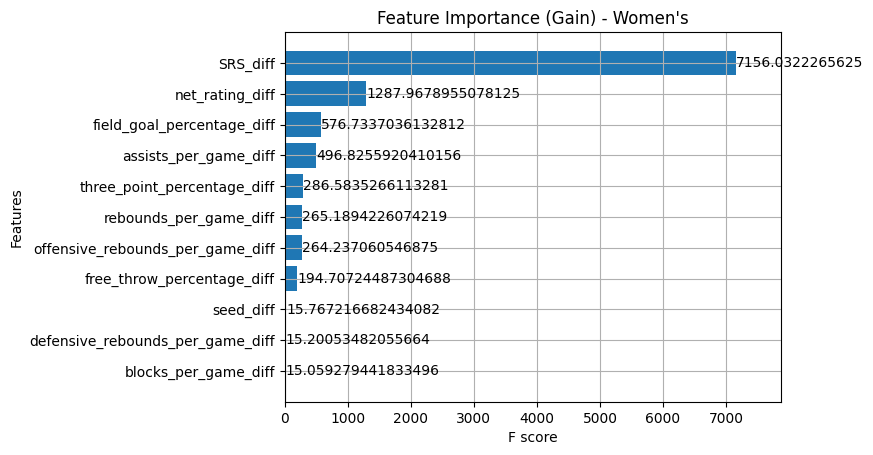

C:\Users\henry-cao-local\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
# Filter out the 2025 season data
xgboost_data_w = xgboost_data_w[xgboost_data_w['Season'] != 2025]

# Split the data into training and testing sets
X = xgboost_data_w.drop(columns=['Season'])
y = combined_df_w.loc[xgboost_data_w.index, 'target']

# Ensure the target variable is binary
y = y.astype(int)

# Use GroupShuffleSplit to split by Season
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(group_split.split(X, y, groups=xgboost_data_w['Season']))

# Split the data
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Drop the non-tournament data from the test data
X_test = X_test[X_test.index.isin(xgboost_data_w[xgboost_data_w['DataSource'] == 'Tournament'].index)]
y_test = y_test[y_test.index.isin(xgboost_data_w[xgboost_data_w['DataSource'] == 'Tournament'].index)]

# Drop the DataSource column
X_train.drop(columns=['DataSource'], inplace=True)
X_test.drop(columns=['DataSource'], inplace=True)

# Verify that seasons are not split
print("Training set seasons:", xgboost_data_w.iloc[train_idx]['Season'].unique())
print("Testing set seasons:", xgboost_data_w.iloc[test_idx]['Season'].unique())

# Create the XGBoost model, with the evaluation method as the Brier Score.
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
import os
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model

# Create Random Forest model
rf_model = RandomForestClassifier(
    random_state=42,  # For reproducibility
    n_jobs=-1,        # Use all available cores
    class_weight='balanced'  # Handle potential class imbalance
)

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
# Get the number of available CPU cores
total_cores = os.cpu_count()
# Calculate cores to use (leave half unallocated)
cores_to_use = max(1, total_cores // 2)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=5,
    n_jobs=cores_to_use,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)  # Negate to get actual Brier score

# Evaluate on test set
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Test set Brier score: {brier_score:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')

# Convert to a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Save the importance_df
importance_df_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Feature_Importance"
importance_df_path = os.path.join(importance_df_dir, 'importance_df_w_v7.csv')
importance_df.to_csv(importance_df_path, index=False)

# Print the top 10 most important features
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Feature Importance (Gain) - Women\'s')

# Save the figure
importance_plot_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Feature_Importance"
importance_plot_path = os.path.join(importance_plot_dir, 'importance_plot_w_v7.png')
plt.savefig(importance_plot_path)

plt.show()

# Save the best model
best_model_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Models"
best_model_path = os.path.join(best_model_dir, 'best_model_w_v7')
best_model.save_model(best_model_path)


In [ ]:
# Make predictions for the women's model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_pred_proba)

# Print results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier_score:.4f}")

# Predict for 2025 season - using women's data
xgboost_data_w_2025_init = combined_df_w_2025.copy()

# Need to drop columns, such as TeamID, that would complicate the model and unimportant columns
xgboost_dropped_columns = ['WScore', 'LScore', 'target',
                           'TeamID1', 'TeamID2', 'games_played_team1', 'games_played_team2', 
                           'losses_team1', 'losses_team2', 'wins_team1', 'wins_team2',
                           'TeamID_srs2', 'TeamID', 'field_goals_made_per_game_team1', 'field_goals_made_per_game_team2',
                           'total_MOV_team1', 'total_MOV_team2', 'personal_fouls_per_game_team1', 'personal_fouls_per_game_team2',
                           'total_points_diff_team1', 'total_points_diff_team2', 'steals_per_game_team1', 'steals_per_game_team2',
                           'ConfAbbrev_team1', 'ConfAbbrev_team2', 'points_per_game_team1', 'points_per_game_team2',
                           'turnovers_per_game_team1', 'turnovers_per_game_team2', 'three_point_field_goals_made_per_game_team1', 'three_point_field_goals_made_per_game_team2',
                           'avg_MOV_team1', 'avg_MOV_team2', 'win_pct_team1', 'win_pct_team2',
                           'offensive_rating_team1', 'offensive_rating_team2', 'defensive_rating_team1', 'defensive_rating_team2']

# Drop the columns
xgboost_data_w_2025 = xgboost_data_w_2025_init.drop(columns=xgboost_dropped_columns)

# Set seed_team1 and seed_team2 to integers
xgboost_data_w_2025['seed_team1'] = xgboost_data_w_2025['seed_team1'].astype(int)
xgboost_data_w_2025['seed_team2'] = xgboost_data_w_2025['seed_team2'].astype(int)

# Find all non-categorical columns
non_categorical_columns = []
for col in xgboost_data_w_2025.columns:
    if combined_df_w_2025[col].dtype != 'object':
        # Check if column ends with _team1 or _team2
        if col.endswith('_team1') or col.endswith('_team2'):
            # Strip the suffix correctly
            col_short = col[:-6]
            if col_short not in non_categorical_columns:
                non_categorical_columns.append(col_short)

# Find the difference between the columns
for col in non_categorical_columns:
    if col != 'Season':
        xgboost_data_w_2025[f"{col}_diff"] = xgboost_data_w_2025[f"{col}_team1"] - xgboost_data_w_2025[f"{col}_team2"]
        xgboost_data_w_2025.drop(columns=[f"{col}_team1", f"{col}_team2"], inplace=True)

# Calculate seed difference
xgboost_data_w_2025['seed_diff'] = xgboost_data_w_2025['seed_team1'] - xgboost_data_w_2025['seed_team2']
xgboost_data_w_2025.drop(columns=['seed_team1', 'seed_team2'], inplace=True)

# Print the columns of xgboost_data_w_2025
print(xgboost_data_w_2025.columns)

# Drop the DataSource column
xgboost_data_w_2025.drop(columns=['DataSource'], inplace=True)

# Drop the Season column
xgboost_data_w_2025.drop(columns=['Season'], inplace=True)

# Make predictions
y_pred_2025 = best_model.predict(xgboost_data_w_2025)
y_pred_proba_2025 = best_model.predict_proba(xgboost_data_w_2025)[:, 1]

# Save the 2025 predictions to a CSV file
output_2025_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions"
output_2025_path = os.path.join(output_2025_dir, 'predictions_2025_w_v7.csv')

# Create a DataFrame with the predictions
y_pred_2025_df = pd.DataFrame({
    'Season': 2025,
    'TeamID1': xgboost_data_w_2025_init['TeamID1'],
    'TeamID2': xgboost_data_w_2025_init['TeamID2'],
    'Predicted_Probability': y_pred_proba_2025
})

# Save the predictions to a CSV file
y_pred_2025_df.to_csv(output_2025_path, index=False)

# Reshape the 2025 predictions for submission
submission_2025_w = reshape_for_submission(y_pred_2025_df)

# Save the reshaped predictions to a CSV file
submission_2025_dir = r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions"
submission_2025_path = os.path.join(submission_2025_dir, 'submission_2025_w_v7.csv')
submission_2025_w.to_csv(submission_2025_path, index=False)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5}
Accuracy: 0.7831
F1 Score: 0.8038
Brier Score: 0.1547
Index(['Season', 'DataSource', 'field_goal_percentage_diff',
       'three_point_percentage_diff', 'free_throw_percentage_diff',
       'offensive_rebounds_per_game_diff', 'defensive_rebounds_per_game_diff',
       'rebounds_per_game_diff', 'assists_per_game_diff',
       'blocks_per_game_diff', 'net_rating_diff', 'SRS_diff', 'seed_diff'],
      dtype='object')


In [128]:
#Mens Probability Matrix
#source: https://github.com/gotoConversion/goto_conversion
#Matrices were computed by converting betting odds to probabilities using goto_conversion

year = 2025

mensProbabilities_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_fivethirtyeight\mensProbabilitiesTable2024.csv", index_col = 'player') #source: https://github.com/gotoConversion/goto_conversion
mensProbabilities_df = mensProbabilities_df.drop('Elo_Rating', axis=1)
womensProbabilities_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_fivethirtyeight\womensProbabilitiesTable2024.csv", index_col = 'player') #source: https://github.com/gotoConversion/goto_conversion
womensProbabilities_df = womensProbabilities_df.drop('Elo_Rating', axis=1)

#Import team seeds
mensTeamSeeds_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\MNCAATourneySeeds.csv")
mensTeamSeeds2025_df = mensTeamSeeds_df.iloc[[x == year for x in mensTeamSeeds_df['Season']]]
womensTeamSeeds_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\data_updated\WNCAATourneySeeds.csv")
womensTeamSeeds2025_df = womensTeamSeeds_df.iloc[[x == year for x in womensTeamSeeds_df['Season']]]

In [ ]:
import pandas as pd
import os
import numpy as np

#Implement Optimal Strategy (if you agree)
def get_roundOfMatch(team1, team2, seeds_df):

    slotMap = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]

    team1_seed = seeds_df.loc[[x == team1 for x in seeds_df['TeamID']],'Seed'].values[0]
    team2_seed = seeds_df.loc[[x == team2 for x in seeds_df['TeamID']],'Seed'].values[0]

    isFirstFourMatch = team1_seed[:3] == team2_seed[:3]
    if isFirstFourMatch:
        return 1

    team1_region = str(team1_seed[:1])
    team2_region = str(team2_seed[:1])

    team1_seedNumber = int(team1_seed[1:3]) #careful with first four teams
    team2_seedNumber = int(team2_seed[1:3]) #careful with first four teams

    isRegionSame = team1_region == team2_region
    if not isRegionSame:

        isTeam1_regionWX = team1_region in ['W','X']
        isTeam2_regionWX = team2_region in ['W','X']

        if isTeam1_regionWX and isTeam2_regionWX: #both W or X region
            return 6

        elif (not isTeam1_regionWX) and (not isTeam2_regionWX): #both not W or X region
            return 6

        else:
            return 7

    else: #same region

        team1_slot = slotMap.index(team1_seedNumber)
        team2_slot = slotMap.index(team2_seedNumber)

        isRound2 = (team1_slot // 2) == (team2_slot // 2)  #round of 64 or first four (not counted anyway)
        if isRound2:
            return 2

        isRound3 = (team1_slot // 4) == (team2_slot // 4)
        if isRound3: #yet to find why but "elif" throws error
            return 3

        isRound4 = (team1_slot // 8) == (team2_slot // 8)
        if isRound4: #yet to find why but "elif" throws error
            return 4

        else:
            return 5

def get_tourneyFlag(team1, team2, seeds_df):

    tourneyTeams = seeds_df['TeamID'].tolist()

    isTeam1InTourney = team1 in tourneyTeams
    isTeam2InTourney = team2 in tourneyTeams

    if isTeam1InTourney and isTeam2InTourney:
        return get_roundOfMatch(team1, team2, seeds_df)

    else:
        return 0

def get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df):
    flag_list = []
    for i in range(submission_df.shape[0]):

        currRow = submission_df.iloc[i,0].split('_')
        team1 = int(currRow[1])
        team2 = int(currRow[2])

        isWomensMatch = team1 + team2 > 6000
        if isWomensMatch:
            flag = get_tourneyFlag(team1, team2, womensTeamSeeds2025_df)
        else:
            flag = get_tourneyFlag(team1, team2, mensTeamSeeds2025_df)

        flag_list.append(flag)
    return flag_list

def set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeam, riskTeamToWinRound):

    flag_list = get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df)

    for i in range(submission_df.shape[0]):
        submission_row = submission_df.iloc[i,0].split('_')
        submission_round = flag_list[i]

        team1 = int(submission_row[1])
        team2 = int(submission_row[2])

        isTeam1Win = (team1 == riskTeam) and (0 < submission_round) and (submission_round <= riskTeamToWinRound)
        isTeam2Win = (team2 == riskTeam) and (0 < submission_round) and (submission_round <= riskTeamToWinRound)
        if isTeam1Win:
            submission_df.at[i, 'Pred'] = 1.0
            print(submission_df.iloc[i])
        elif isTeam2Win:
            submission_df.at[i, 'Pred'] = 0.0
            print(submission_df.iloc[i])
    
    return submission_df

# Loop through all years from 2003 to 2025

import pandas as pd
import os
import numpy as np

#Implement Optimal Strategy (if you agree)
def get_roundOfMatch(team1, team2, seeds_df):

    slotMap = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]

    team1_seed = seeds_df.loc[[x == team1 for x in seeds_df['TeamID']],'Seed'].values[0]
    team2_seed = seeds_df.loc[[x == team2 for x in seeds_df['TeamID']],'Seed'].values[0]

    isFirstFourMatch = team1_seed[:3] == team2_seed[:3]
    if isFirstFourMatch:
        return 1

    team1_region = str(team1_seed[:1])
    team2_region = str(team2_seed[:1])

    team1_seedNumber = int(team1_seed[1:3]) #careful with first four teams
    team2_seedNumber = int(team2_seed[1:3]) #careful with first four teams

    isRegionSame = team1_region == team2_region
    if not isRegionSame:

        isTeam1_regionWX = team1_region in ['W','X']
        isTeam2_regionWX = team2_region in ['W','X']

        if isTeam1_regionWX and isTeam2_regionWX: #both W or X region
            return 6

        elif (not isTeam1_regionWX) and (not isTeam2_regionWX): #both not W or X region
            return 6

        else:
            return 7

    else: #same region

        team1_slot = slotMap.index(team1_seedNumber)
        team2_slot = slotMap.index(team2_seedNumber)

        isRound2 = (team1_slot // 2) == (team2_slot // 2)  #round of 64 or first four (not counted anyway)
        if isRound2:
            return 2

        isRound3 = (team1_slot // 4) == (team2_slot // 4)
        if isRound3: #yet to find why but "elif" throws error
            return 3

        isRound4 = (team1_slot // 8) == (team2_slot // 8)
        if isRound4: #yet to find why but "elif" throws error
            return 4

        else:
            return 5

def get_tourneyFlag(team1, team2, seeds_df):

    tourneyTeams = seeds_df['TeamID'].tolist()

    isTeam1InTourney = team1 in tourneyTeams
    isTeam2InTourney = team2 in tourneyTeams

    if isTeam1InTourney and isTeam2InTourney:
        return get_roundOfMatch(team1, team2, seeds_df)

    else:
        return 0

def get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df):
    flag_list = []
    for i in range(submission_df.shape[0]):

        currRow = submission_df.iloc[i,0].split('_')
        team1 = int(currRow[1])
        team2 = int(currRow[2])

        isWomensMatch = team1 + team2 > 6000
        if isWomensMatch:
            flag = get_tourneyFlag(team1, team2, womensTeamSeeds2025_df)
        else:
            flag = get_tourneyFlag(team1, team2, mensTeamSeeds2025_df)

        flag_list.append(flag)
    return flag_list

def set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeam, riskTeamToWinRound):

    flag_list = get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df)

    for i in range(submission_df.shape[0]):
        submission_row = submission_df.iloc[i,0].split('_')
        submission_round = flag_list[i]

        team1 = int(submission_row[1])
        team2 = int(submission_row[2])

        isTeam1Win = (team1 == riskTeam) and (0 < submission_round) and (submission_round <= riskTeamToWinRound)
        isTeam2Win = (team2 == riskTeam) and (0 < submission_round) and (submission_round <= riskTeamToWinRound)
        if isTeam1Win:
            submission_df.at[i, 'Pred'] = 1.0
            print(submission_df.iloc[i])
        elif isTeam2Win:
            submission_df.at[i, 'Pred'] = 0.0
            print(submission_df.iloc[i])
    
    return submission_df

# Loop through all years from 2003 to 2025

submission_m_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions\submission_2025_m_v7.csv")
submission_w_df = pd.read_csv(r"C:\Users\henry-cao-local\Desktop\Self_Learning\Kaggle\March_Machine_Learning_Mania_2025\March_Madness_2025_Kaggle\Predictions\submission_2025_w_v7.csv")

# Combine the two DataFrames
submission_df = pd.concat([submission_m_df, submission_w_df], ignore_index=True)

riskTeam = 1179 #Drake
riskTeamToWinRound = 2 #Near Optimal Probability for Strategy
submission_df = set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeam, riskTeamToWinRound)
submission_df.to_csv('submission_combined_v7.csv', index=False)

ID      2025_1179_1281
Pred               1.0
Name: 23679, dtype: object
